# Preprocessing files 


In [1]:
#!python3 -m pip install python_speech_features # Install PSF specifically on python3.
import os
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import h5py
from python_speech_features import mfcc
import matplotlib.pyplot as plt
import tracemalloc
from SerialTriggerDecoder import SerialTriggerDecoder
from scipy import signal

tracemalloc.start() # Enable memory profiling

#

## Find files, and list structure

In [2]:

# OS walk through the directory to find the files
#root_dir = '//uni.au.dk/dfs/Tech_EarEEG/Students/Msc2022_BCM_AkselStark'
root_dir = 'bcm_activity_dataset'
data = [] # Empty list to store all hdf5 files in the directory

for subdir, dirs, files in sorted(os.walk(root_dir)):
    for file in files:
        if "hdf5" in file:
            print("\n\n\n")
            # Load the hdf5 file, and append to the list
            print(file)
            
            data.append(h5py.File(os.path.join(subdir, file), 'r'))
            
            print(f'{subdir}/{file}') # Print the filename
            keylist = list(data[0].keys())
            print( keylist) # Print the keys of the hdf5 file
            
            
data = data[1:] # Create subset of the files, to create training and validation set

for i,j in enumerate(data):
    print("\n\n\n")
    print(f'Index of the hdf5 file: {i}') # Print the index of the hdf5 file
    for key in keylist:
        print(key)
        try: # Try to print the keys. If it fails, print the data
            print(f"    {list(data[i][key].keys())}")
        except:
            print("    No subkeys")
            print(f"    {np.array(data[i][key])}")
            s = data[i][key]
                        
                        







2022-09-20_14-58-39.hdf5
bcm_activity_dataset/2022-09-20_14-58-39.hdf5
['DAQ970A', 'streaminfo']




2022-09-20_15-57-37.hdf5
bcm_activity_dataset/2022-09-20_15-57-37.hdf5
['DAQ970A', 'streaminfo']




2022-09-20_15-18-27.hdf5
bcm_activity_dataset/2022-09-20_15-18-27.hdf5
['DAQ970A', 'streaminfo']




2022-09-20_15-38-11.hdf5
bcm_activity_dataset/2022-09-20_15-38-11.hdf5
['DAQ970A', 'streaminfo']




Index of the hdf5 file: 0
DAQ970A
    ['data', 'labels']
streaminfo
    No subkeys
    [(4, b'cf_float32', 5233.929, b'5125-240-002', b'DAQ970A', 50000, b'DAQ970A_TCPIP_192_168_56_100', b'Generic')]




Index of the hdf5 file: 1
DAQ970A
    ['data', 'labels']
streaminfo
    No subkeys
    [(4, b'cf_float32', 2884.1384, b'5125-240-002', b'DAQ970A', 50000, b'DAQ970A_TCPIP_192_168_56_100', b'Generic')]




Index of the hdf5 file: 2
DAQ970A
    ['data', 'labels']
streaminfo
    No subkeys
    [(4, b'cf_float32', 4067.6292, b'5125-240-002', b'DAQ970A', 50000, b'DAQ970A_TCPIP_192_168_56_100'

## Load data, and labels/triggers

In [3]:
# Load data

print(f'Memory usage: {tracemalloc.get_traced_memory()[0]/1000000} MB\n')
data_bcm = []
labels_bcm = []
for file in data:
    print(f"data    {file}")
    data_full = np.array(file['DAQ970A']['data'])
    data_bcm.append(data_full[:,0])
    data_bcm.append(data_full[:,1])
    print(f'Memory usage: {tracemalloc.get_traced_memory()[0]/1000000} MB\n')

    print(f"Labels    {file}")
    labels_bcm.append(file['DAQ970A']['data'][:,3])
    print(f'Memory usage: {tracemalloc.get_traced_memory()[0]/1000000} MB\n')

pass

Memory usage: 0.156605 MB

data    <HDF5 file "2022-09-20_15-57-37.hdf5" (mode r)>
Memory usage: 784.156932 MB

Labels    <HDF5 file "2022-09-20_15-57-37.hdf5" (mode r)>
Memory usage: 980.158148 MB

data    <HDF5 file "2022-09-20_15-18-27.hdf5" (mode r)>
Memory usage: 1764.15974 MB

Labels    <HDF5 file "2022-09-20_15-18-27.hdf5" (mode r)>
Memory usage: 1960.159852 MB

data    <HDF5 file "2022-09-20_15-38-11.hdf5" (mode r)>
Memory usage: 2744.1605 MB

Labels    <HDF5 file "2022-09-20_15-38-11.hdf5" (mode r)>
Memory usage: 2940.160612 MB



## Plot cepstrum


In [18]:
# Plot spectrogram
#plt.pcolormesh(t[0:20], f, np.log(spectrogram_list[segment_index]),shading='auto')
#plt.pcolormesh(np.log(data_mfcc[4][20605:20610,1:].transpose()),shading='auto')
def plot_mfcc(data_mfcc):
    fig = plt.figure(figsize=(30, 5))
    plt.pcolormesh((data_mfcc),shading='auto')
    plt.ylabel('Mel Cepstrum Coefficients')
    plt.xlabel('Time [sec]')
    plt.show()

# Create the labels

## Plot and test the manchester encoding

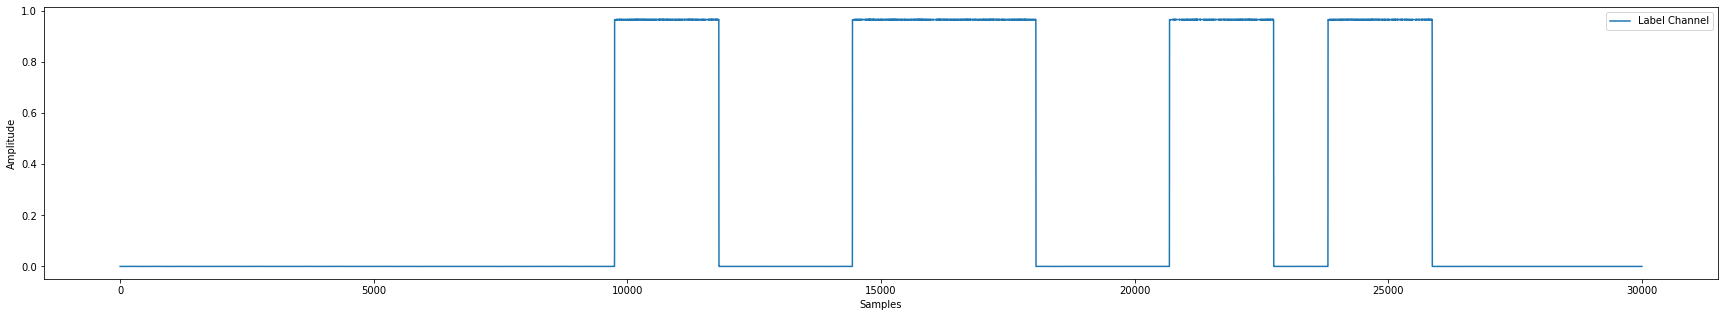

In [19]:
# Doesn't work right now

# Plot the label channel
pos = 0

fig = plt.figure(figsize=(30, 5))

jump = 2 # Measured: clock of manchester encoding
seg_len = 60000
segment = labels_bcm[0][pos:pos+seg_len][0::jump]

plt.plot(segment, label='Label Channel')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.legend()

plt.grid(which = 'minor')

#decode signal from manchester encoding
def manchester_decode(data):
    manchester_decoded = []
    for i in range(0,data.shape[0]-1,2):
        if data[i] == 0 and data[i+1] == 1:
            manchester_decoded.append(0)
        elif data[i] == 1 and data[i+1] == 0:
            manchester_decoded.append(1)
        else:
            manchester_decoded.append(8888) #error
    return manchester_decoded
    

#print(np.rint(segment))
#print(manchester_decode(np.rint(segment)))
plt.show()

## Find the sections, and label them

In [4]:
# Creates a list of the positions of the triggers (and plot them for verification)

last_decoded = -500000
label_index_list = [] # List of the indices of the labels
for i, j in enumerate(np.rint(labels_bcm[0])):
    
    if int(j) and (i > last_decoded+50000*8):
        #print(manchester_decode(np.rint(labels_bcm[0][i-900:i+100000][0::2480])))
        print(f"i: {i}")
        print(f"Time: {i/50000} s")
        last_decoded = i
        
        label_index_list.append(i)
        ''' # Plot
        fig = plt.figure(figsize=(30, 5))
        plt.plot(labels_bcm[1][i-900:i+50000], label='Label Channel')
        plt.xlabel('Samples')
        plt.ylabel('Amplitude')
        plt.legend()

        plt.grid(which = 'minor')
        plt.show()
        '''
    


i: 21350
Time: 0.427 s
i: 521347
Time: 10.42694 s
i: 1021344
Time: 20.42688 s
i: 1521341
Time: 30.42682 s
i: 2021339
Time: 40.42678 s
i: 2521336
Time: 50.42672 s
i: 3021333
Time: 60.42666 s
i: 3521330
Time: 70.4266 s
i: 4021327
Time: 80.42654 s
i: 4521324
Time: 90.42648 s
i: 5021084
Time: 100.42168 s
i: 5521081
Time: 110.42162 s
i: 6021078
Time: 120.42156 s
i: 6521075
Time: 130.4215 s
i: 7021072
Time: 140.42144 s
i: 7469096
Time: 149.38192 s
i: 8021066
Time: 160.42132 s
i: 8521064
Time: 170.42128 s
i: 9021061
Time: 180.42122 s
i: 9521058
Time: 190.42116 s
i: 10018479
Time: 200.36958 s
i: 10518476
Time: 210.36952 s
i: 11018473
Time: 220.36946 s
i: 11518470
Time: 230.3694 s
i: 12018467
Time: 240.36934 s
i: 12518464
Time: 250.36928 s
i: 13018461
Time: 260.36922 s
i: 13518459
Time: 270.36918 s
i: 14018456
Time: 280.36912 s
i: 14518453
Time: 290.36906 s
i: 15022377
Time: 300.44754 s
i: 15522374
Time: 310.44748 s
i: 16022371
Time: 320.44742 s
i: 16522368
Time: 330.44736 s
i: 17022366
Time: 3

In [5]:
# Make a list of the labels for the triggers

index_labels = [] # A list of labels for the indexes in label_index_list

for i in range(6):
    index_labels.extend([0,0,0,1,1,1,2,2,2,-1])

for i in range(18): index_labels.append(3)
index_labels.append(-1)

for i in range(18): index_labels.append(4)
index_labels.append(-1)

## Concatenate the data from each class, calculate the mfcc's and save to 5 files (one for each class)

In [6]:
# Add the sections to 5 lists corresponding to the 5 different labels/classes
''' 
Classes:
    Breathing: 0
    Snoring: 1
    Hold_breath: 2
    Chewing: 3
    Talking: 4
'''
fs = 50000
nested_class_list = [[],[],[],[],[]]


for datastream in data_bcm: # Loop through the data 
    for i, j in enumerate(label_index_list):
        if index_labels[i]>=0:
            nested_class_list[index_labels[i]].append(datastream[j:j+fs*10]) # Append 
            


In [9]:

# Concatenate the arrays, calc mfccs and save them to files
for i, j in enumerate(nested_class_list):
    stacked_array = np.hstack(j)
    
    # Plot the stacked array
    '''fig = plt.figure(figsize=(30, 5))
    plt.plot(stacked_array, label=f'Data for label {i}')
    plt.xlabel('Samples')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(which = 'minor')
    plt.show()'''
    
    # Create and save mfccs
    data_mfcc = mfcc(stacked_array, samplerate = fs, nfft = 1600, winlen=0.032, winstep=0.032, numcep=16) # Sample rate is important when using mel scale
    
    #plot_mfcc(data_mfcc)
    np.save(f'data/bcm/train/{i}.npy', data_mfcc)
    
    '''# Create and save periodogram data
    f,t, Pxx = signal.spectrogram(stacked_array, fs = fs ,nperseg=int(0.032*fs), noverlap = 0)
    print(data_mfcc.shape)
    print(Pxx.shape)
    pass
    Pxx_out = np.zeros(data_mfcc.shape)
    for i, row in enumerate(Pxx):
        if i '''
    
    #np.save(f'data/bcm_spectrograms/{i}.npy', data_mfcc)
    
    
    

In [24]:


# Plot the full measurements
'''for i in data_bcm:
    fig = plt.figure(figsize=(30, 5))
    plt.plot(i, label='Label Channel')
    plt.xlabel('Samples')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(which = 'minor')
    plt.show()
'''
'''
for i in data_bcm: 
    mfccs = mfcc(i, samplerate = fs, nfft = 1600, winlen=0.032, winstep=0.032, numcep=16)
    plot_mfcc(mfccs)
'''
'''
for i in labels_bcm:
    fig = plt.figure(figsize=(30, 5))
    plt.plot(i, label='Label Channel')
    plt.xlabel('Samples')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(which = 'minor')
    plt.show()'''

"\nfor i in labels_bcm:\n    fig = plt.figure(figsize=(30, 5))\n    plt.plot(i, label='Label Channel')\n    plt.xlabel('Samples')\n    plt.ylabel('Amplitude')\n    plt.legend()\n    plt.grid(which = 'minor')\n    plt.show()"

In [25]:
# Import the dataset class, and make sure the data is unchanged after loading
from BCM_dataset_v2 import bcmDataset
from BCM_dataset_v2 import concat_train_test_datasets

train_set, val_set = concat_train_test_datasets('data/bcm/', window_size = 3, stride = 3, MFCC_stride = 0.032)


data/bcm//0.npy
data/bcm//1.npy
data/bcm//2.npy
data/bcm//3.npy
data/bcm//4.npy


torch.Size([93, 16])
tensor([0., 0., 0., 0., 1.])
tensor([0., 1., 0., 0., 0.])
tensor([0., 1., 0., 0., 0.])
tensor([0., 0., 1., 0., 0.])
(372, 16)


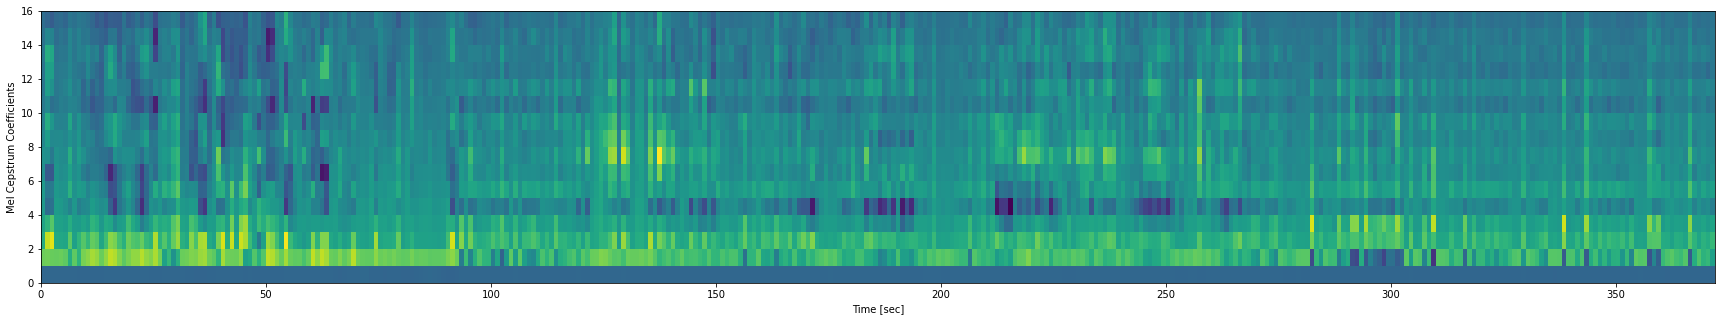

In [26]:

print(train_set[0][0].shape)

mfcc_from_dataset_list = []

for i,j in enumerate(val_set):
    if i > 4:
        mfcc_from_dataset_list.append(j[0])
        print(j[1])
    if len(mfcc_from_dataset_list) > 3: break
    
dataset_mfccs = np.vstack(mfcc_from_dataset_list)

print(dataset_mfccs.shape)
    

plot_mfcc(dataset_mfccs.transpose())